# Map interpolation

## Scope 

- This NB computes XY maps using run 6819 to correct energy and lifetime. Then interpolates the geometrical and lifetime maps.

- Voltage in the anode 7.7 kV!
- New DAQ, lower PMT gain. 


### Author:  JJGC

### Software: KrCalib : https://github.com/nextic/ICAROS/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Thu Jan 31 09:06:04 2019


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-01-31 09:06:05,785 | INFO : Hello world!


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"


run_number  = 6817
first_file  ='0000'
last_file   = 9999
input_file_names  = [f'dst_{run_number}_trigger1_{first_file}_{last_file}.h5']

time_bins = 10
output_file_name  = ' '
map_file_name     = ''
map_file_name_ts  = ''
emap_file_name    = f'kr_emap_xy_100_100_r_{run_number}.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core.core_functions      import timeit
from krcal.core                     import fit_functions_ic as fitf

In [10]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [11]:
from krcal.core.stat_functions      import mean_and_std

In [12]:
from krcal.core.analysis_functions  import kr_ranges_and_bins
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [13]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [14]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [15]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [16]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName
from krcal.core.kr_types import ASectorMap


In [17]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [18]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

In [19]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [20]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [21]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [22]:
import krcal.dev.corrections       as corrections 


In [23]:
from numpy import pi, sqrt

In [24]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [25]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [26]:
import logging
log = logging.getLogger()

### Input/output 

In [27]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [28]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6817_trigger1_0000_9999.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_100_100_r_6817.h5')

In [29]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [30]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 730303


In [31]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [117]:
RMAX      = 160
RFID      = 180
RCORE     = 100
s1e_range = (1, 25)
s2e_range = (1000, 15000)
s2w_range =(4, 15)
s2q_range = (200, 800)
Nsipm_min = 10
xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 7000)
c2_range = (0,10)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 25,
                                                        ynbins    = 25,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [118]:
krRanges

KrRanges(S2e=(1000, 15000), S1e=(1, 25), S2q=(200, 800), X=(-160, 160), Y=(-160, 160), Z=(10, 550), T=(1548181483.109, 1548288561.479))

In [119]:
krNbins

KrNBins(S2e=25, S1e=10, S2q=25, X=25, Y=25, Z=15, T=29)

In [120]:
dstx = dst[in_range(dst.X, *xy_range)]
dsty = dstx[in_range(dstx.Y, *xy_range)]
dst  = dst[in_range(dst.R, 0, RMAX)]
#dst = dsty

In [121]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [122]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)  # kge = krypton general event; it simply selects a krEvent from the existing DST

```
@dataclass
class KrEvent(Point):
    """Adds raw energy/time"""
    S2e  : Array
    S1e  : Array
    S2q  : Array
    T    : Array  # time
    DT   : Array  # time difference in seconds
    E    : Array
    Q    : Arra`
````

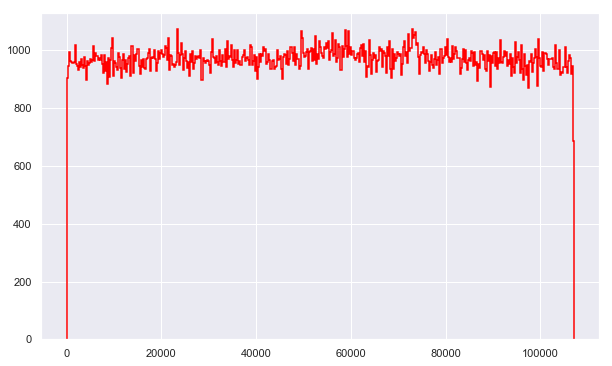

In [123]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Event distribution

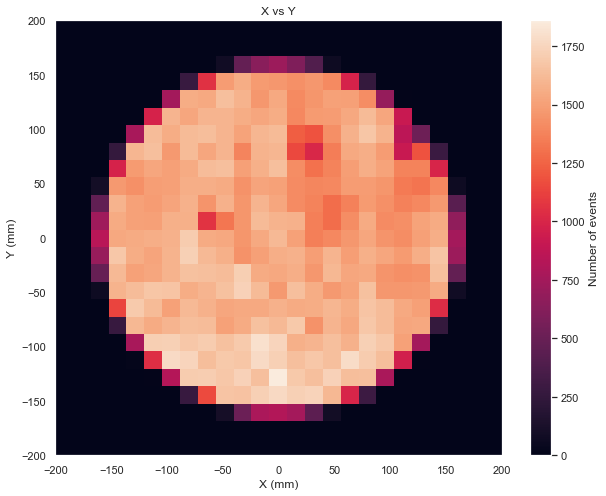

In [124]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, (-200,200), (-200,200), 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

## Single time XY map. 

- Compute a single-time (or time-averaged) map, with a fine-grain in XY. 
- The energy map (e0 correction) is invariant and can be added for many maps.
- The lt map (lt correction) represents an average-over-run. A correction function may use such a map or add a time-dependent correction, fitting the time dependence. 

## Divide chamber in sectors of XY
```
def select_xy_sectors(dst        : DataFrame,
                      time_diffs : np.array,
                      E          : np.array,
                      Q          : np.array,
                      bins_x     : np.array,
                      bins_y     : np.array)-> Dict[int, List[KrEvent]]:
    """
    Return a dict of KrEvent organized by xy sector
```

In [125]:
log.setLevel(logging.INFO) # turn to DEBUG to follow progress of this part 

In [126]:
ti = timeit(select_xy_sectors)
KXY = ti(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)

Time spent in select_xy_sectors: 1.7493000030517578 s


In [127]:
nXY = event_map(KXY)

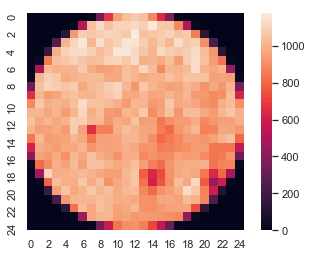

In [128]:
ax = sns.heatmap(nXY, square=True)

In [129]:
nXY

0     1     2     3     4     5     6     7     8     9  ...     15  \
0      0     0     0     0     0     0     0    38   348   678 ...    647   
1      0     0     0     0     0    22   532  1049  1119  1052 ...   1065   
2      0     0     0     0   142   931  1087  1063  1082  1109 ...   1074   
3      0     0     0   256  1011  1108  1160  1015  1132  1055 ...   1073   
4      0     0   178   998  1095  1125  1128  1090  1031  1068 ...   1119   
5      0    33   847  1044  1063  1094  1057  1037  1043  1092 ...    984   
6      0   498  1029  1001  1009  1010  1075   985   947   950 ...    892   
7     36  1014  1095  1071   982  1004  1015  1035  1023   974 ...    999   
8    326  1043  1100  1084  1062  1080   979  1025  1041  1082 ...    979   
9    657  1015   940   966  1028  1045  1008  1005  1041  1064 ...    973   
10   886  1064   996  1013   989  1038  1131  1051  1049  1035 ...    956   
11  1010  1015   968  1008   941  1011  1116   993  1036   936 ...    959   
12  1050   980  1013   977  1004  1079  1080  1013  1020   926 ...    845   
13  1011   948   954   981   937  1082   957   667   861   864 ...    859   
14   845  1018   943   955   966  1013   980   842   957   960 ...    805   
15   620   985   963   942   974   976  1008   928   964   954 ...    860   
16   385   954   934   989   915  1018   980  1040   988   967 ...    890   
17    40   819   900   994   960  1032   945  1048  1046  1004 ...    817   
18     0   470  1113   990   995  1006  1022  1004   975   948 ...    733   
19     0    25   794  1039   995   991  1066   984  1043   911 ...    759   
20     0     0   192   957  1051   977  1010  1066  1009  1043 ...    909   
21     0     0     0   225   926  1012  1008  1009  1036  1026 ...    968   
22     0     0     0     0   152   826  1039   977  1040  1021 ...    930   
23     0     0     0     0     0    21   462   973  1008  1018 ...    928   
24     0     0     0     0     0     0     0    26   330   592 ...    568   

      16    17    18    19    20   21    22    23   24  
0    385    27     0     0     0    0     0     0    0  
1   1061   892   516    26     0    0     0     0    0  
2   1098  1053  1068   854   146    0     0     0    0  
3   1013  1135  1070  1086   905  226     0     0    0  
4   1081  1061  1080  1120  1034  923   138     0    0  
5   1037   942  1085  1129  1042  939   841    27    0  
6   1014  1002  1017  1133  1001  976  1005   449    0  
7   1045  1008  1056  1046  1045  949   958   949   32  
8    949   964  1014   987   919  975   925  1005  361  
9   1010   972  1025   942   930  890   903  1032  622  
10  1063   979   996   970   916  901   997  1032  909  
11  1048   928  1028  1028   979  939  1015  1055  996  
12   904   940   941   985   889  926   950   953  994  
13   811   924   967  1021   867  878   970   968  935  
14   847   888   939   936   917  948  1005  1042  801  
15   866   890   909   943   937  838   834   842  566  
16   896   954   930   944   896  833   854   918  309  
17   925   972   993   988  1002  837   874   879   33  
18   914   971   997   969   843  636   805   492    0  
19   904  1036   972  1120   772  449   603    27    0  
20   947  1002  1132  1070   870  607   111     0    0  
21   975   955  1026   999   880  241     0     0    0  
22   960   963   968   734   150    0     0     0    0  
23   902   891   430    31     0    0     0     0    0  
24   314    25     0     0     0    0     0     0    0  

[25 rows x 25 columns]

## Fits in XY sectors

## Maps

#### The first step is to fit a map XY (in time series) for the number of time bins required (in this case 1)
```
def fit_map_xy(selection_map : Dict[int, List[KrEvent]],
               event_map     : DataFrame,
               n_time_bins   : int,
               time_diffs     : np.array,
               nbins_z       : int,
               nbins_e       : int,
               range_z       : Tuple[float, float],
               range_e       : Tuple[float, float],
               energy        : str                 = 'S2e',
               fit           : FitType             = FitType.profile,
               n_min         : int                 = 100)->Dict[int, List[FitParTS]]:
 ```

In [49]:
ti = timeit(fit_map_xy)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = ti(selection_map = KXY,
              event_map     = nXY,
              n_time_bins   = 1,
              time_diffs    = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy        = 'S2e',
              fit           = FitType.unbined,
              n_min         = 100)


Time spent in fit_map_xy: 5.9627158641815186 s


#### The second step is to obtain the maps themselves from the fit-map-XY
```
def tsmap_from_fmap(fMap : Dict[int, List[FitParTS]])->SectorMapTS:
    """
    Obtain a time-series of maps (tsmap) from a fit-map (fmap).

    Parameters
    ----------
    fMap
        A Dictionary (key = R sector for Rphi maps, X for XYmaps) containing a list of FitParTS
        (list runs over Phi wedges for RPhi maps, Y for Ymaps)
        class ASectorMap:
            chi2  : DataFrame
            e0    : DataFrame
            lt    : DataFrame
            e0u   : DataFrame
            ltu   : DataFrame

            class FitParTS:
                ts   : np.array -> contains the time series (integers expressing time differences)
                e0   : np.array ->e0 fitted in time series
                lt   : np.array
                c2   : np.array
                e0u  : np.array
                ltu  : np.array

    Returns
    -------
    SectorMapTS : Maps in chamber sector containing time series of parameters
        class SectorMapTS:
            chi2  : Dict[int, List[np.array]]
            e0    : Dict[int, List[np.array]]
            lt    : Dict[int, List[np.array]]
            e0u   : Dict[int, List[np.array]]
            ltu   : Dict[int, List[np.array]]

    """
```

In [50]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy)

Time spent in tsmap_from_fmap: 0.0011899471282958984 s


#### Third step: select the corresponding map in the time series (in this case just one, ts=0)
```
def amap_from_tsmap(tsMap      : SectorMapTS,
                    ts         : int  = 0,
                    range_e    : Tuple[float, float] = (5000, 13000),
                    range_chi2 : Tuple[float, float] = (0,3),
                    range_lt   : Tuple[float, float] = (1800, 3000)) ->ASectorMap:
    """
    Obtain the correction maps for time bin ts.

    Parameters
    ----------
    tsMap
        A SectorMapTS : Maps in chamber sector containing time series of parameters
        class SectorMapTS:
            chi2  : Dict[int, List[np.array]]
            e0    : Dict[int, List[np.array]]
            lt    : Dict[int, List[np.array]]
            e0u   : Dict[int, List[np.array]]
            ltu   : Dict[int, List[np.array]]
    ts
        time bin (an integer starting at 0: if -1 take the average of the series).
    range_e
        Defines the range of e in pes (e.g, (8000,14000)).
    range_chi2
        Defines the range of chi2
    range_lt
        Defines the range of lt in mus.

    Returns
    -------
    A container of maps ASectorMap
        class ASectorMap:
            chi2  : DataFrame
            e0    : DataFrame
            lt    : DataFrame
            e0u   : DataFrame
            ltu   : DataFrame

    """
```


In [51]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

#### Am contains the maps in XY bins for the single time series (ts=0). We can now compute the map average, draw, etc:

In [55]:
am.e0.index

RangeIndex(start=0, stop=50, step=1)

In [56]:
am.e0

0            1            2            3             4   \
0           NaN          NaN          NaN          NaN           NaN   
1           NaN          NaN          NaN          NaN           NaN   
2           NaN          NaN          NaN          NaN           NaN   
3           NaN          NaN          NaN          NaN           NaN   
4           NaN          NaN          NaN          NaN           NaN   
5           NaN          NaN          NaN          NaN           NaN   
6           NaN          NaN          NaN          NaN           NaN   
7           NaN          NaN          NaN          NaN           NaN   
8           NaN          NaN          NaN          NaN           NaN   
9           NaN          NaN          NaN          NaN           NaN   
10          NaN          NaN          NaN          NaN           NaN   
11          NaN          NaN          NaN          NaN   8215.924098   
12          NaN          NaN          NaN  8106.395943   8892.905215   
13          NaN          NaN          NaN  8698.827975   9321.758923   
14          NaN          NaN  8241.015116  9020.734955   9482.158247   
15          NaN          NaN  8594.981665  9146.185026   9645.869139   
16          NaN  8191.914390  8901.463450  9340.031266   9695.892930   
17          NaN  8368.074202  9032.936057  9455.242656   9807.157922   
18          NaN  8598.197148  9182.726139  9542.885973   9921.861890   
19  8060.055187  8569.820070  9312.587528  9609.140547   9933.469620   
20  8017.246091  8780.597600  9366.348197  9843.043598  10098.018727   
21  8077.245106  9013.860466  9454.731784  9953.242329  10207.749334   
22  8185.599228  9022.813182  9585.322623  9963.141206  10236.374064   
23  8172.533723  8941.738438  9508.454961  9944.750644  10144.222649   
24  8183.008745  8949.128388  9495.488841  9906.824759  10079.680898   
25  8049.172727  8933.112397  9447.613666  9849.252564  10017.831084   
26  8007.450102  8896.714298  9415.688415  9714.661050   9918.132824   
27  7865.490119  8743.228040  9349.302221  9683.108603   9855.828094   
28  7673.418927  8485.757797  9125.623442  9555.853350   9724.788036   
29          NaN  8163.806183  8862.637505  9310.075871   9642.155014   
30          NaN  8034.795462  8604.409249  9152.134178   9510.873780   
31          NaN  7728.234494  8649.032966  9063.538111   9388.565828   
32          NaN  7581.559291  8363.192576  8919.572877   9218.663631   
33          NaN          NaN  8025.518241  8616.756184   9097.241830   
34          NaN          NaN  7662.235454  8366.135741   8806.460358   
35          NaN          NaN          NaN  7941.909202   8493.057039   
36          NaN          NaN          NaN  7405.179048   8221.854192   
37          NaN          NaN          NaN          NaN   7732.198826   
38          NaN          NaN          NaN          NaN           NaN   
39          NaN          NaN          NaN          NaN           NaN   
40          NaN          NaN          NaN          NaN           NaN   
41          NaN          NaN          NaN          NaN           NaN   
42          NaN          NaN          NaN          NaN           NaN   
43          NaN          NaN          NaN          NaN           NaN   
44          NaN          NaN          NaN          NaN           NaN   
45          NaN          NaN          NaN          NaN           NaN   
46          NaN          NaN          NaN          NaN           NaN   
47          NaN          NaN          NaN          NaN           NaN   
48          NaN          NaN          NaN          NaN           NaN   
49          NaN          NaN          NaN          NaN           NaN   

              5             6             7             8             9   \
0            NaN           NaN           NaN           NaN           NaN   
1            NaN           NaN           NaN           NaN           NaN   
2            NaN           NaN           NaN           NaN           NaN   
3            NaN           NaN      

In [212]:
amap_average(am) 

ASectorMap(chi2=0.9868500732695245, e0=9838.504693189056, lt=4317.797814102642, e0u=29.00779410768804, ltu=168.69754459799654, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [213]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2019-01-30 09:20:58,303 | INFO :  set nans to average value of interval = 9500.0
2019-01-30 09:20:58,357 | INFO :  set nans to average value of interval = 3500.0


In [214]:
amap_average(rmap)

ASectorMap(chi2=0.9868500732695245, e0=9838.504693189056, lt=4317.797814102642, e0u=29.00779410768804, ltu=168.69754459799654, mapinfo=None)

In [215]:
asm = relative_errors(rmap)

In [216]:
amv = amap_average(asm)
amv

ASectorMap(chi2=0.9868500732695245, e0=9838.504693189056, lt=4317.797814102642, e0u=0.30892196330433014, ltu=3.997425201485921, mapinfo=None)

#### Draw the maps using default colormap

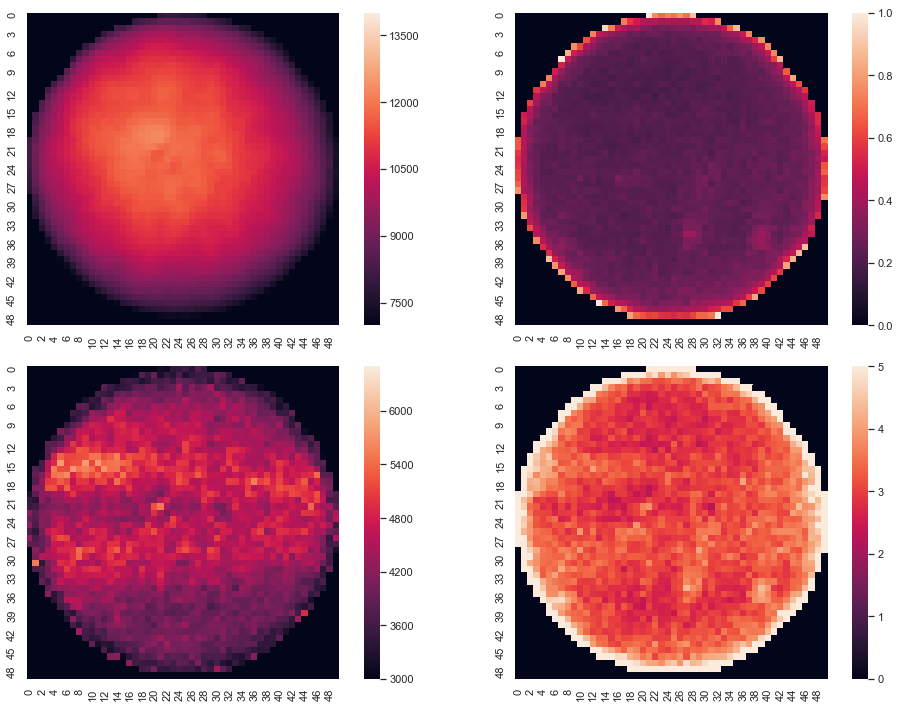

In [217]:
draw_xy_maps(asm,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

#### The dark spots correspond to regions of low statistic, where the fits did not work. To avoid this effect, it is necessary to use more statistic for the XY maps. 

In [218]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [219]:
amap_average(asmAv)

ASectorMap(chi2=0.9824084181609137, e0=10014.968953337184, lt=4340.184644671201, e0u=0.2935045446770456, ltu=3.7600576354547917, mapinfo=None)

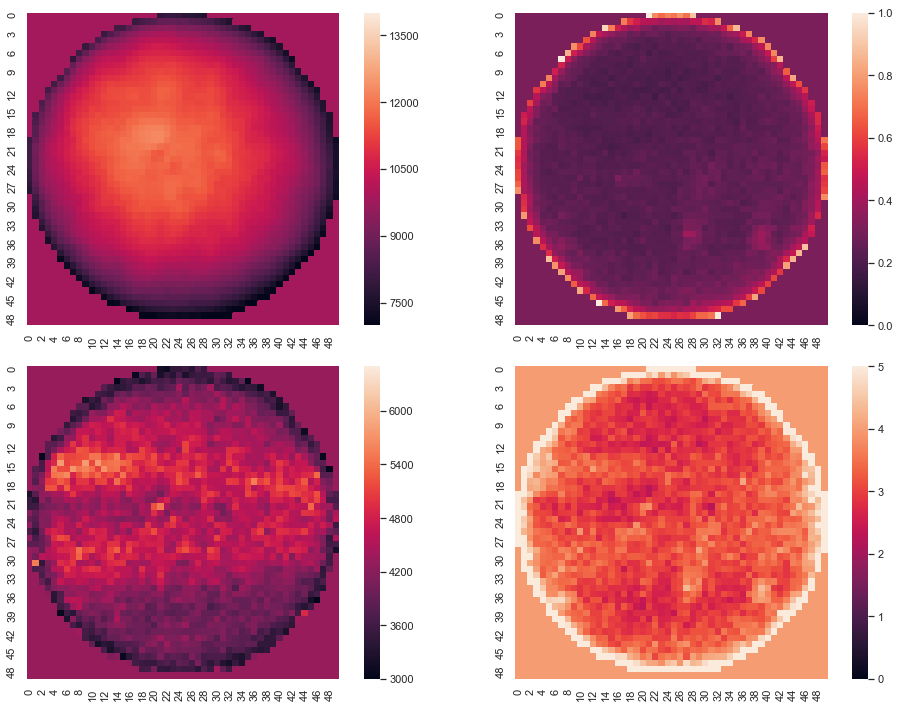

In [220]:
draw_xy_maps(asmAv,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [221]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)

In [222]:
asm.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    6817
dtype: int64

### Save to file

In [223]:
write_maps(asm, filename=fn.emap_file_name)

### Read back

In [224]:
fn.emap_file_name

'/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_100_100_r_6817.h5'

In [225]:
emaps = read_maps(filename=fn.emap_file_name)

In [226]:
emaps.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    6817
dtype: int64

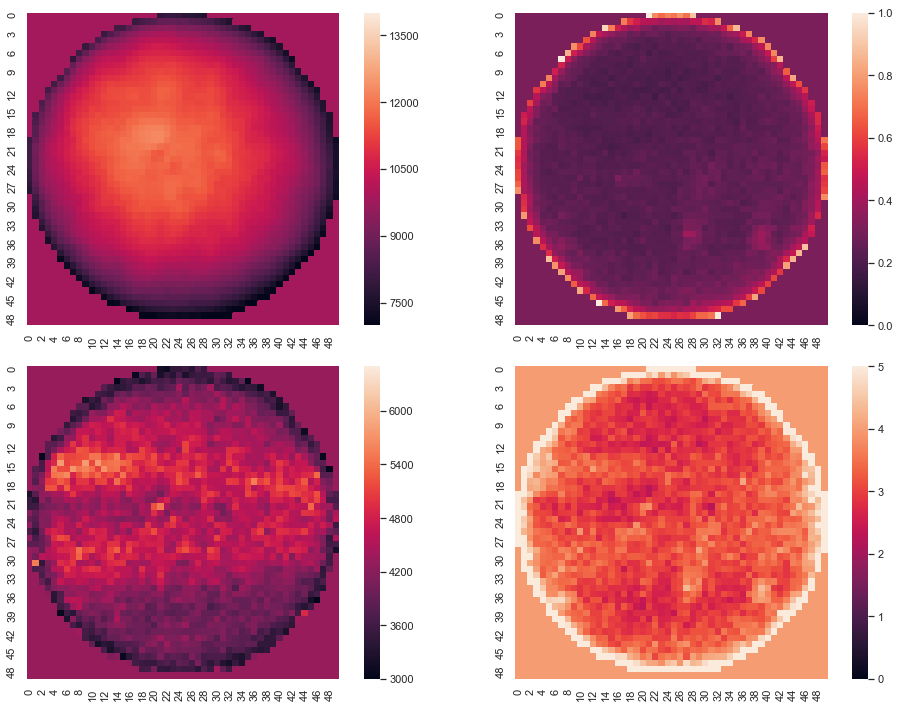

In [227]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

## Now check the corrections that can be achieved with the single maps

In [228]:
amap_average(emaps)

ASectorMap(chi2=0.9824084181609137, e0=10014.968953337184, lt=4340.184644671201, e0u=0.2935045446770456, ltu=3.7600576354547917, mapinfo=None)

In [229]:
norm = amap_max(emaps)

In [230]:
norm

ASectorMap(chi2=28.151101604299807, e0=12289.57975640193, lt=5779.4767114591805, e0u=1.2066850917730194, ltu=19.90755073419182, mapinfo=None)

#### E0 correction:
```
def e0_xy_correction(E   : np.array,
                     X   : np.array,
                     Y   : np.array,
                     E0M : DataFrame,
                     xr  : Tuple[int, int],
                     yr  : Tuple[int, int],
                     nx  : int,
                     ny  : int)->np.array:
    """
    Computes the energy vector corrected by geometry in bins of XY.

    Parameters
    ----------
    E
        The uncorrected energy vector.
    X
        Array of X bins.
    Y
        Array of Y bins.
    E0M
        Map of geometrical corrections (E0 map).
    xr
        Range of X (e.g, (-220,220)).
    yr
        Range of Y (e.g, (-220,220)).
    nx
        Number of bins in X.
    ny
        Number of bins in Y.

    Returns
    -------
    np.array
        The corrected energy vector (by energy).

    """
```


In [231]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 6.8135528564453125 s


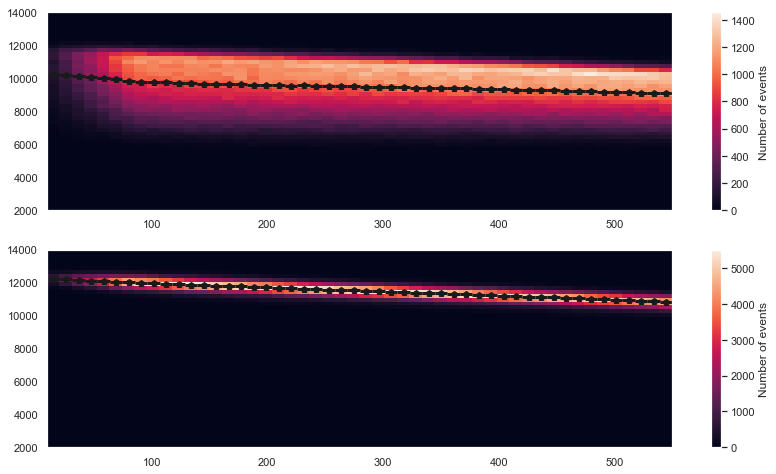

In [232]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

#### To see the effect of the E0 correction, we can now recompute the RPHI maps. 

In [233]:
ti = timeit(select_rphi_sectors)
KRP = ti(dst, DT, E0, dst.S2q, W) # Passing now the E0 vector to the kre_event

Time spent in select_rphi_sectors: 0.8257231712341309 s


In [234]:
neM = event_map(KRP)

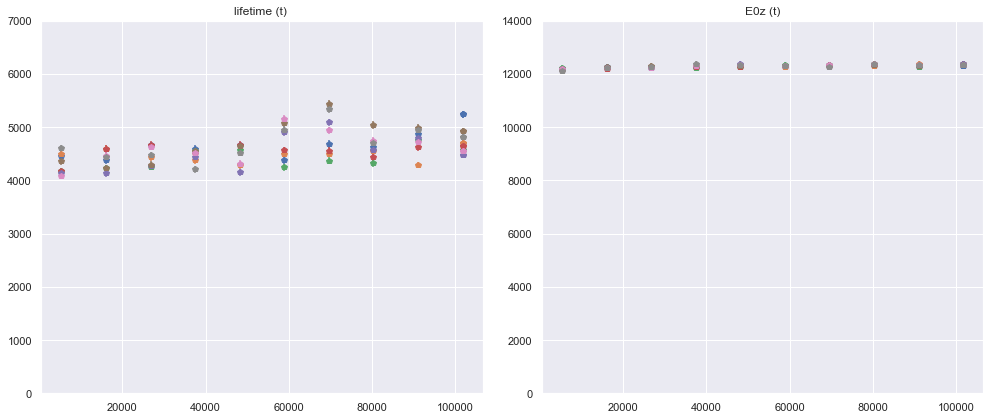

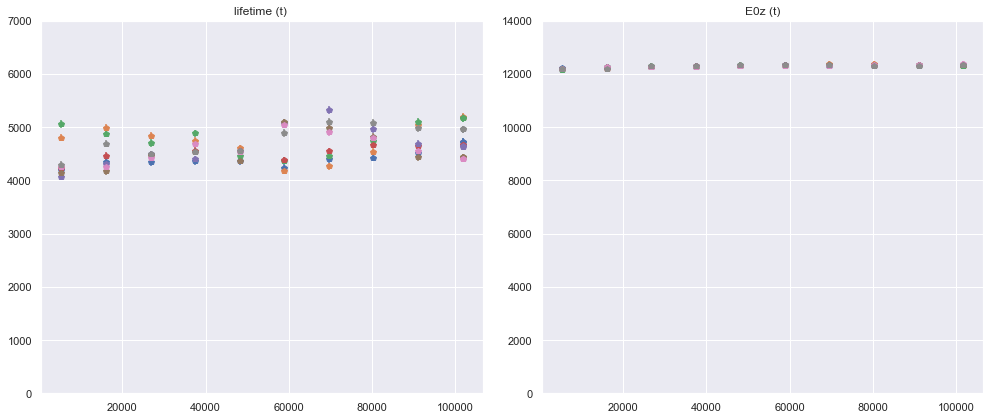

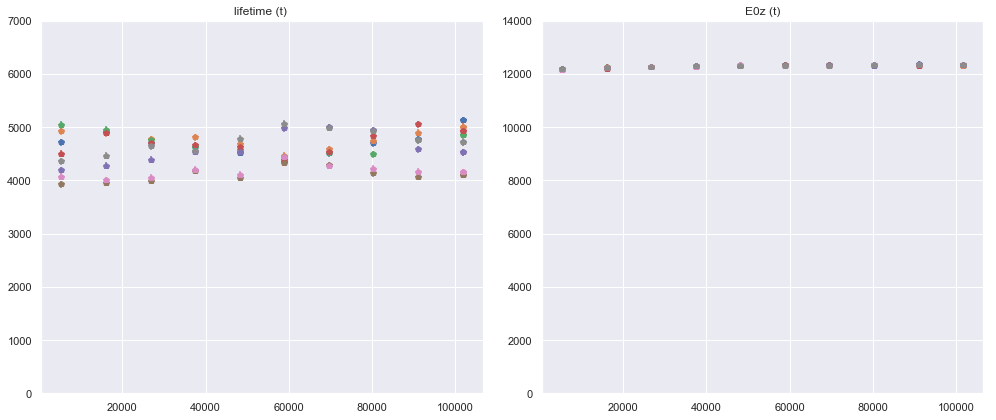

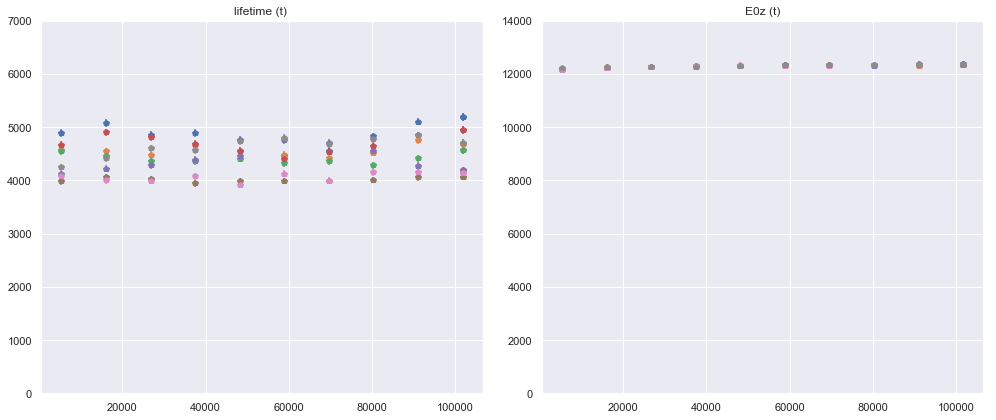

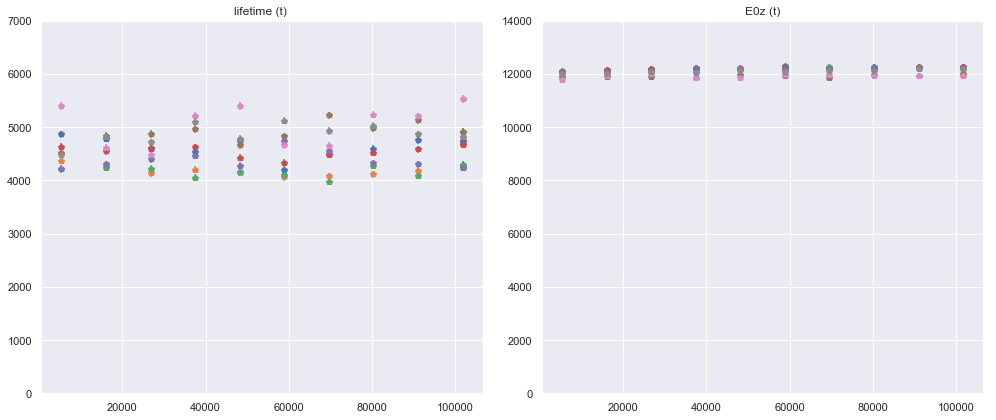

In [235]:
for sector in range(NSECTORS):
    frs = fit_fcs_in_rphi_sectors(sector = sector,
                                  selection_map = KRP,
                                  event_map     = neM,
                                  n_time_bins   = time_bins,
                                  time_diffs    =DT,
                                  nbins_z       = 25,
                                  nbins_e       = 50,
                                  range_z       =(50, 550),
                                  range_e       = (5000, 15500),
                                  energy        = 'E',                        #use corrected energy
                                  fit           = FitType.unbined,
                                  n_min         = 100)
    plot_fit_sectors(frs,  range_e0 =erange, range_lt=ltrange)
    

#### And also the explicit RPHI maps

In [236]:
ti = timeit(fit_map_rphi)
fmrp = ti(selection_map    = KRP,
          event_map     = neM,
          n_time_bins   = time_bins,
          time_diffs    = DT,
          nbins_z       = krNbins.Z, 
          nbins_e       = krNbins.S2e, 
          range_z       = z_range, 
          range_e       = e_range,
          energy        = 'E',
          fit           = FitType.unbined,
          n_min         = 100)
t1 = time.time()


Time spent in fit_map_rphi: 1.3827059268951416 s


In [237]:
tsmrp = tsmap_from_fmap(fmrp)

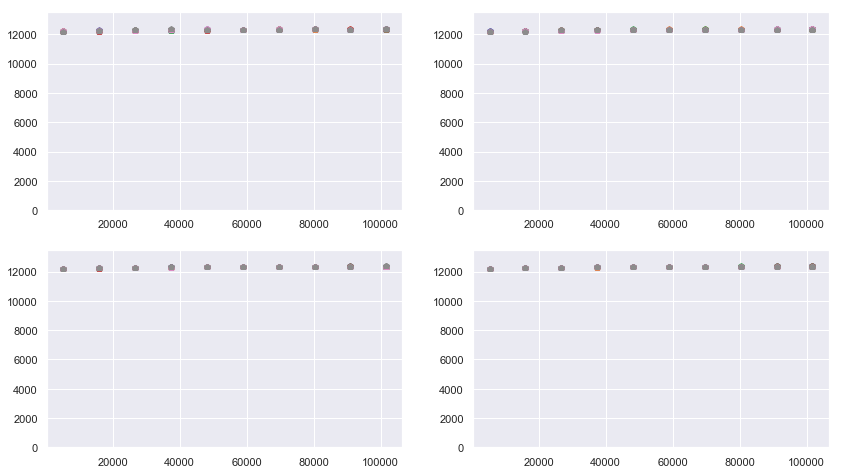

In [238]:
erange=(0, 13500)
fig = plt.figure(figsize=(14,8))
for j in range(0,4):
    ax      = fig.add_subplot(2, 2, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsmrp.e0[j][i], np.sqrt(tsmrp.e0[j][i]), fmt="p")
        plt.ylim(erange)

#### Notice that E0 correction has leveled all the sectors

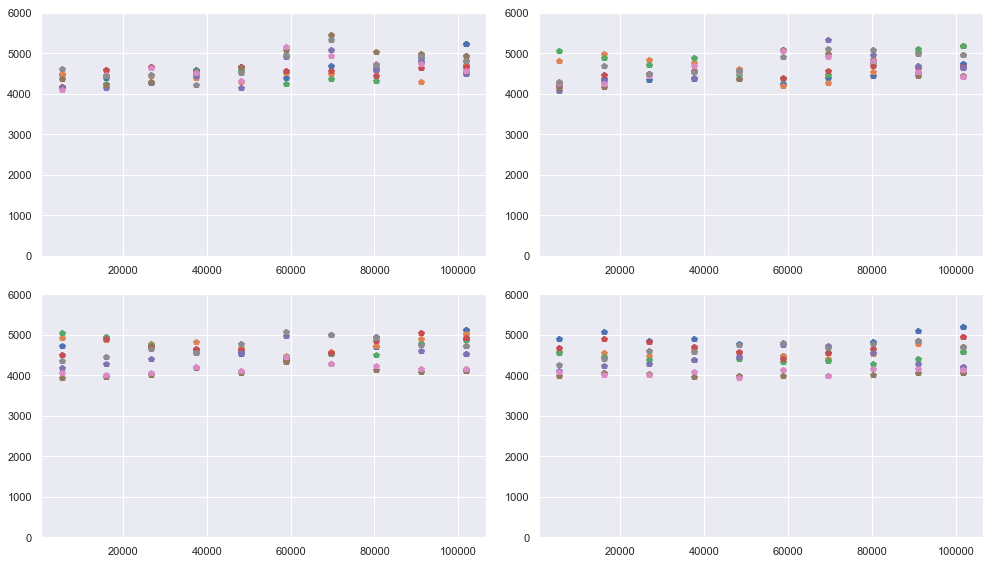

In [239]:
fig = plt.figure(figsize=(14,8))
ltrange=(0, 6000)
for j in range(0,4):
    ax      = fig.add_subplot(2, 2, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsmrp.lt[j][i], np.sqrt(tsmrp.lt[j][i]), fmt="p")
        plt.ylim(ltrange)
plt.tight_layout()

#### RPHI map average (in time)

In [240]:
amts0 = amap_from_tsmap(tsmrp, 
                        ts = 0, 
                        range_e     = e_range,
                        range_chi2  = c2_range,
                         range_lt    = lt_range)

In [241]:
avam = amap_average(amts0) 
avam

ASectorMap(chi2=0.9341269642269033, e0=12144.11577089925, lt=4427.126125220771, e0u=18.50035549818886, ltu=87.61395815388792, mapinfo=None)

In [242]:
asm0 = relative_errors(amts0)

In [243]:
amap_average(asm0) 

ASectorMap(chi2=0.9341269642269033, e0=12144.11577089925, lt=4427.126125220771, e0u=0.1525880543313202, ltu=1.959112617686111, mapinfo=None)

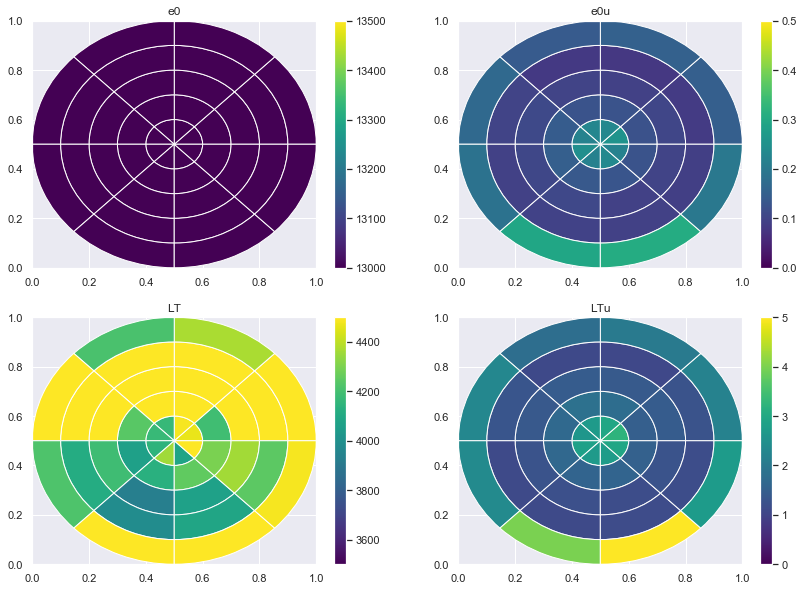

In [244]:
draw_rphi_maps(W, asm0,  
          e0lims  = (13000, 13500),
          ltlims  = (3500, 4500),
          eulims  = (0, 0.5),
          lulims  = (0,5),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

### Maps for the full time series

In [248]:
aMaps = []
EE    = []
LT    = []
TT    = []
t0 = time.time()
for i, tt in enumerate(ts):
    am = amap_from_tsmap(tsmrp, 
                         ts = i, 
                         range_e     = (5000, 13000),
                         range_chi2  = (0,100),
                         range_lt    = (2000,7000))
    amv = amap_average(am) 
    asm = relative_errors(am)
    av = amap_replace_nan_by_mean(asm, amMean=amv)
    av0 = amap_average(av) 
    aMaps.append(av)
    EE.append(av0.e0)
    LT.append(av0.lt)
    TT.append(tt)
t1 = time.time()
print(f' t = {t1 -t0}')

 t = 0.16832208633422852


(0, 13500)

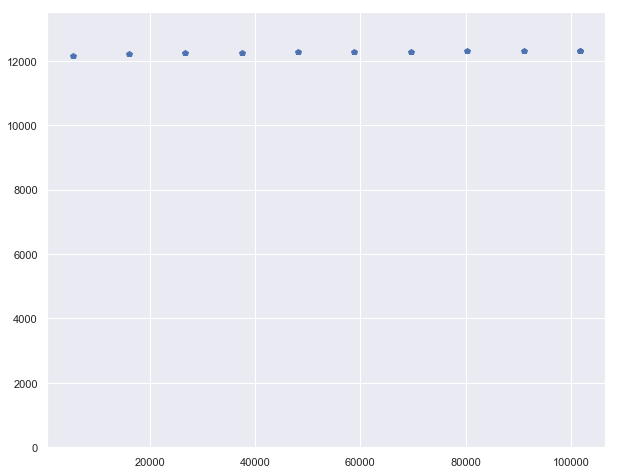

In [249]:
plt.errorbar(TT, EE, 10, fmt="p")
plt.ylim(0,13500)

(4000, 5500)

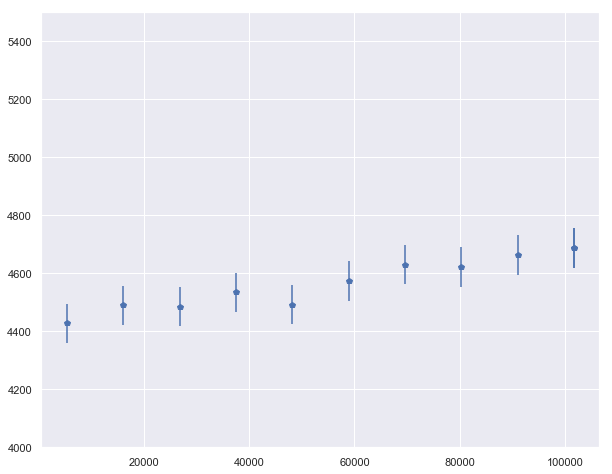

In [250]:
plt.errorbar(TT, LT, sqrt(LT), fmt="p")
plt.ylim(4000,5500)

#### Plot above is the average evolution of lifetime with time across the run.

## XY (single time) LT correction


```
def lt_xy_correction(E    : np.array,
                     X    : np.array,
                     Y    : np.array,
                     Z    : np.array,
                     LTM  : DataFrame,
                     xr   : Tuple[int, int],
                     yr   : Tuple[int, int],
                     nx   : int,
                     ny   : int)->np.array:
    """
    Computes the energy vector corrected by lifetime in bins of XY.

    Parameters
    ----------
    E
        The uncorrected energy vector.
    X
        Array of X bins.
    Y
        Array of Y bins.
    LTM
        Map of lifetime corrections (LT map).
    xr
        Range of X (e.g, (-220,220)).
    yr
        Range of Y (e.g, (-220,220)).
    nx
        Number of bins in X.
    ny
        Number of bins in Y.

    Returns
    -------
    np.array
        The corrected energy vector (by lifetime).

    """
```


In [251]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 6.999835968017578 s


In [252]:
krRanges.S2e

(2000, 14000)

In [253]:
er = (5000,15000)

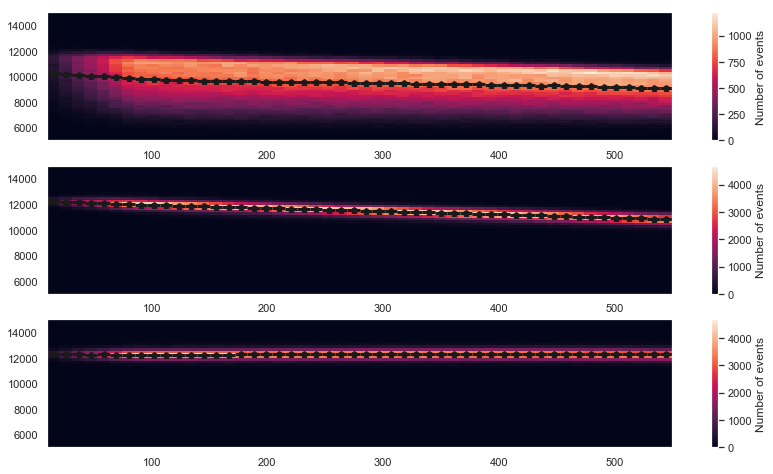

In [254]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, er, 
           profile=True)

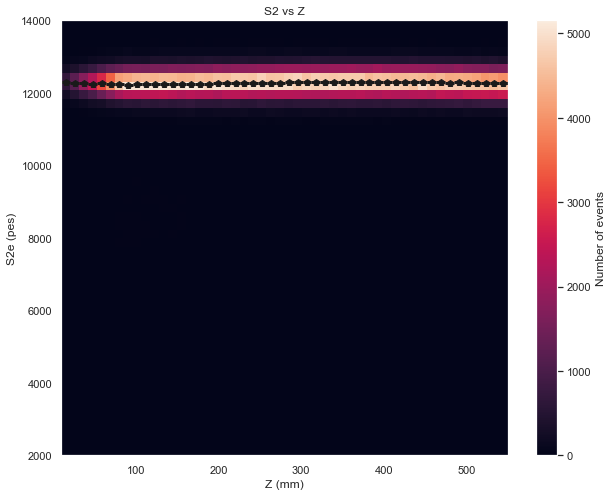

In [255]:
nevt = h2d(dst.Z, E, 50, 50, krRanges.Z, (2000,14000),  
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

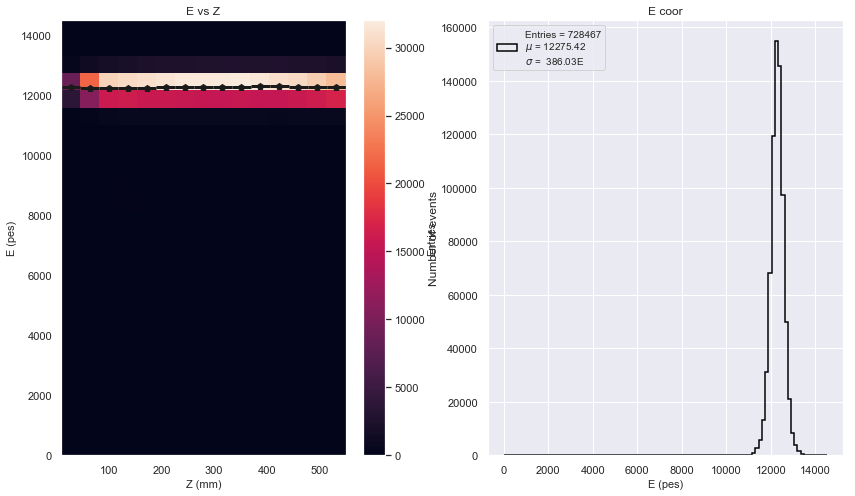

In [256]:
e_range = (0, 14500)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12293.096586133179 +-0.32550108100253283 
 E sigma   = 272.88632882671925 +-0.2558089065811398 
 chi2    = 10.630038128159836 
 sigma E/E (FWHM)     (%) =5.216609730913269
 sigma E/E (FWHM) Qbb (%) =0.6737353522309909 


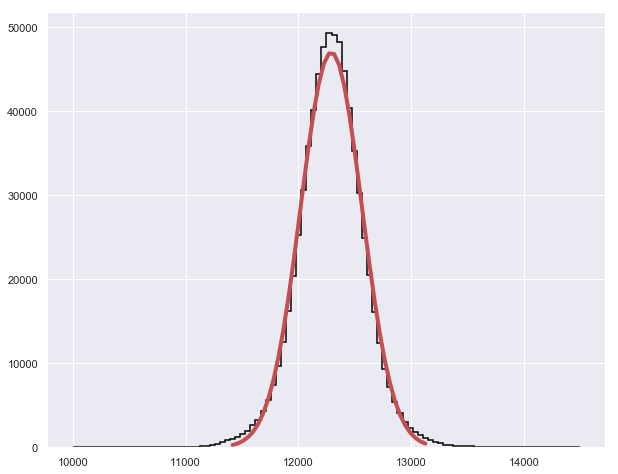

In [257]:
fc = fit_energy(E, nbins=100, range=(10000, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

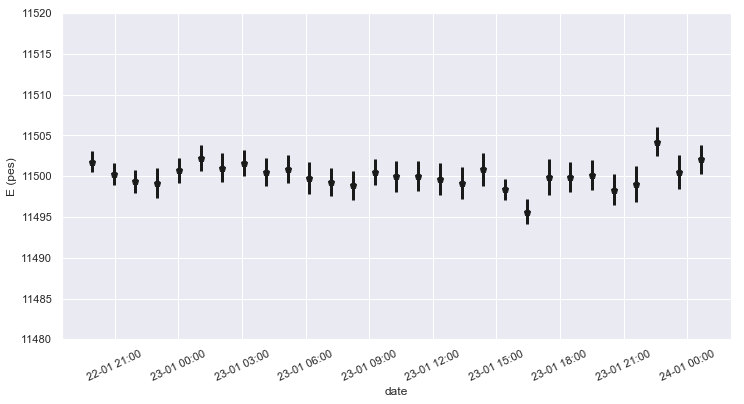

In [258]:
baseline = 11500
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(T, E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(e1, e2),
                    figsize=(12,6))

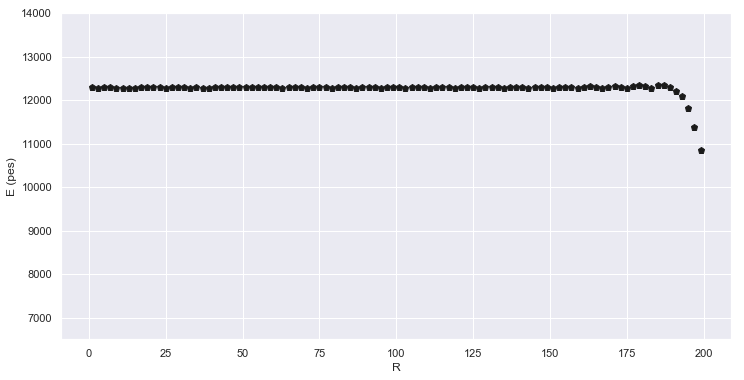

In [259]:
energy_X_profile(dst.R, E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

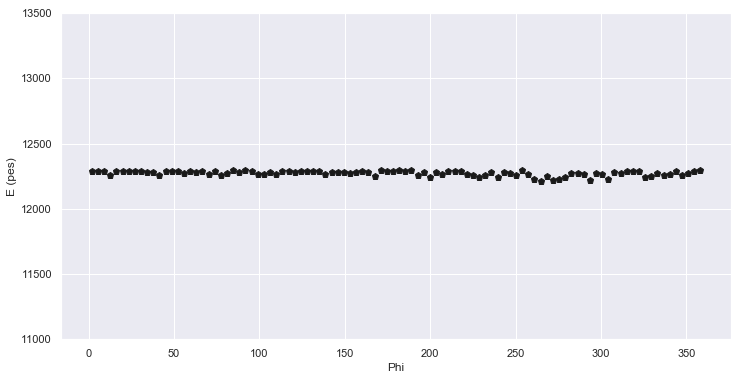

In [260]:
energy_X_profile(phirad_to_deg(dst.Phi), E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

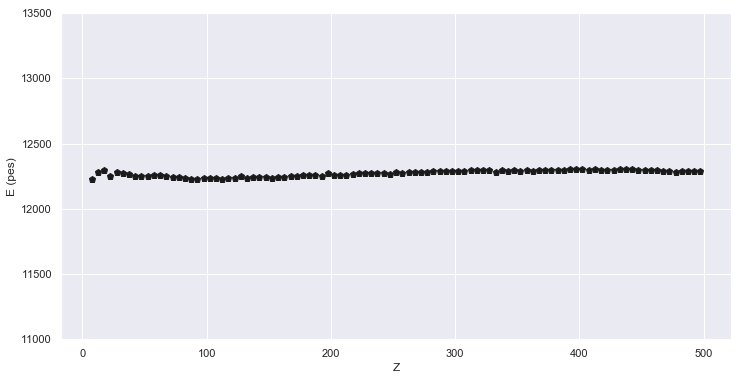

In [261]:
energy_X_profile(dst.Z, E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

### Select events in the region

- R < 180
- 10 < z < 550
- 11000 < E < 13500

In [262]:
rrange = (0, 180)
sel = in_range(dst.R, *rrange) & in_range(dst.Z, *z_range) &  in_range(E, *e_range)

In [263]:
kse = kr_event(dst, DT, E, dst.S2q, sel)  # kse = krypton selected event

### Repeat profles

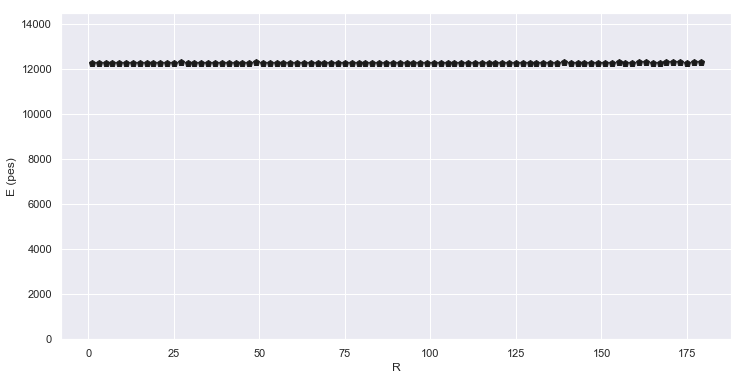

In [264]:
energy_X_profile(kse.R, kse.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))

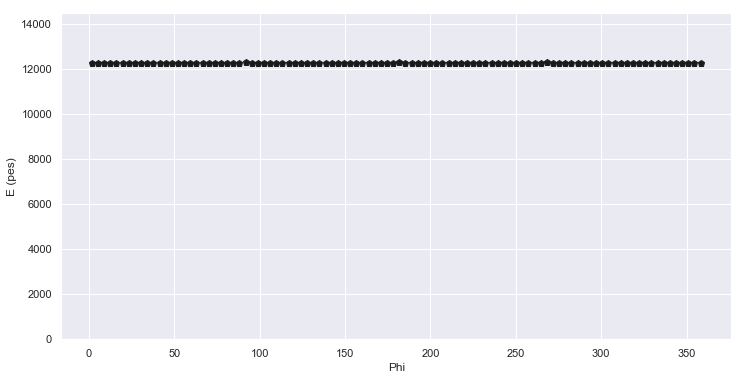

In [265]:
energy_X_profile(phirad_to_deg(kse.Phi), kse.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))

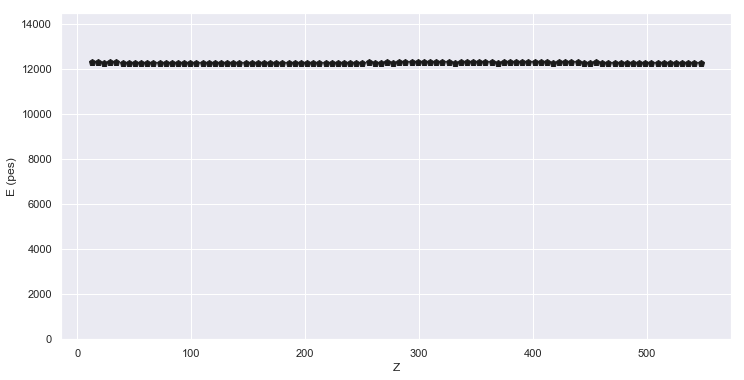

In [266]:
energy_X_profile(kse.Z, kse.E, xnbins = 100, xrange=zrange, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))

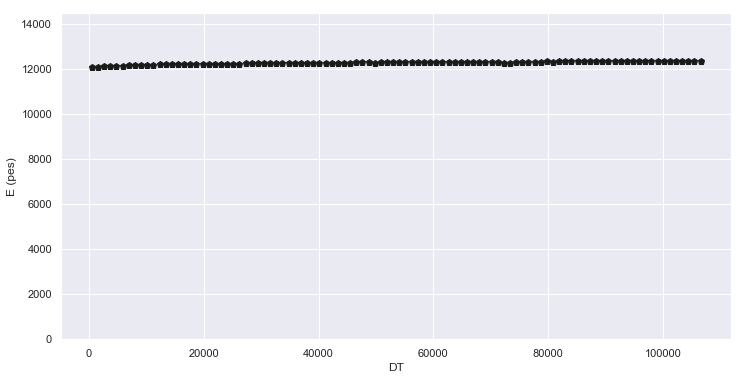

In [267]:
energy_X_profile(kse.DT, kse.E, xnbins = 100, xrange=(kse.DT[0], kse.DT[-1]), xlabel = 'DT',
                 erange=e_range,   
                 figsize=(12,6))

#### Everything is flat. No need for further corrections. 

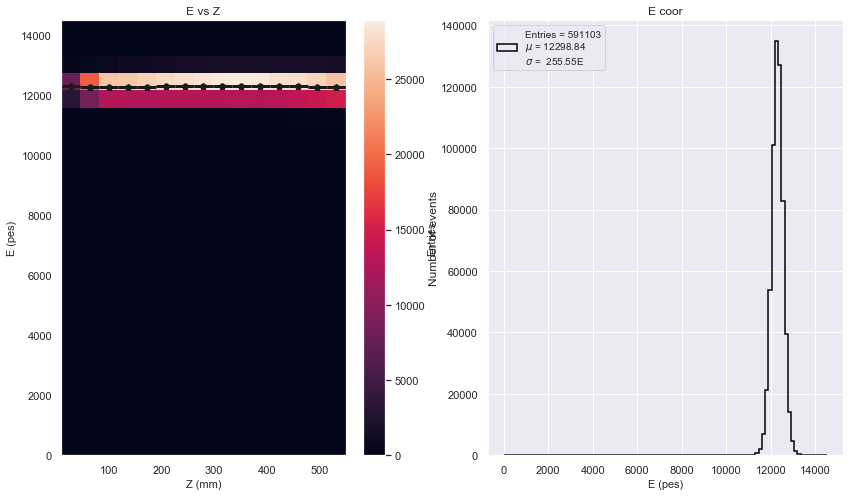

In [268]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(kse.Z, kse.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kse.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12298.054694483892 +-0.32910231879552426 
 E sigma   = 249.2998226003527 +-0.25236358899154426 
 chi2    = 4.464054330820716 
 sigma E/E (FWHM)     (%) =4.763798809364584
 sigma E/E (FWHM) Qbb (%) =0.6152539358590146 


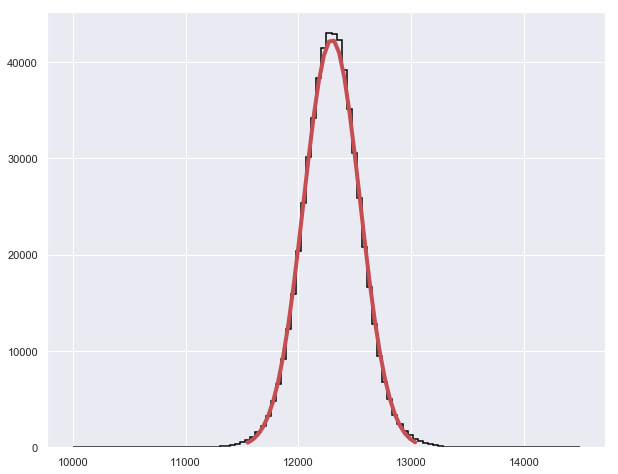

In [269]:
fc = fit_energy(kse.E, nbins=100, range=(10000, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

 fit failed for seed  = GaussPar(mu=Measurement(value=12286.185364729852, uncertainty=3.2065788082844744), std=Measurement(value=212.67620348501197, uncertainty=2.267651380632277), amp=Measurement(value=2393.0023584739142, uncertainty=5.68415906769889)), due to RunTimeWarning, retry fit 


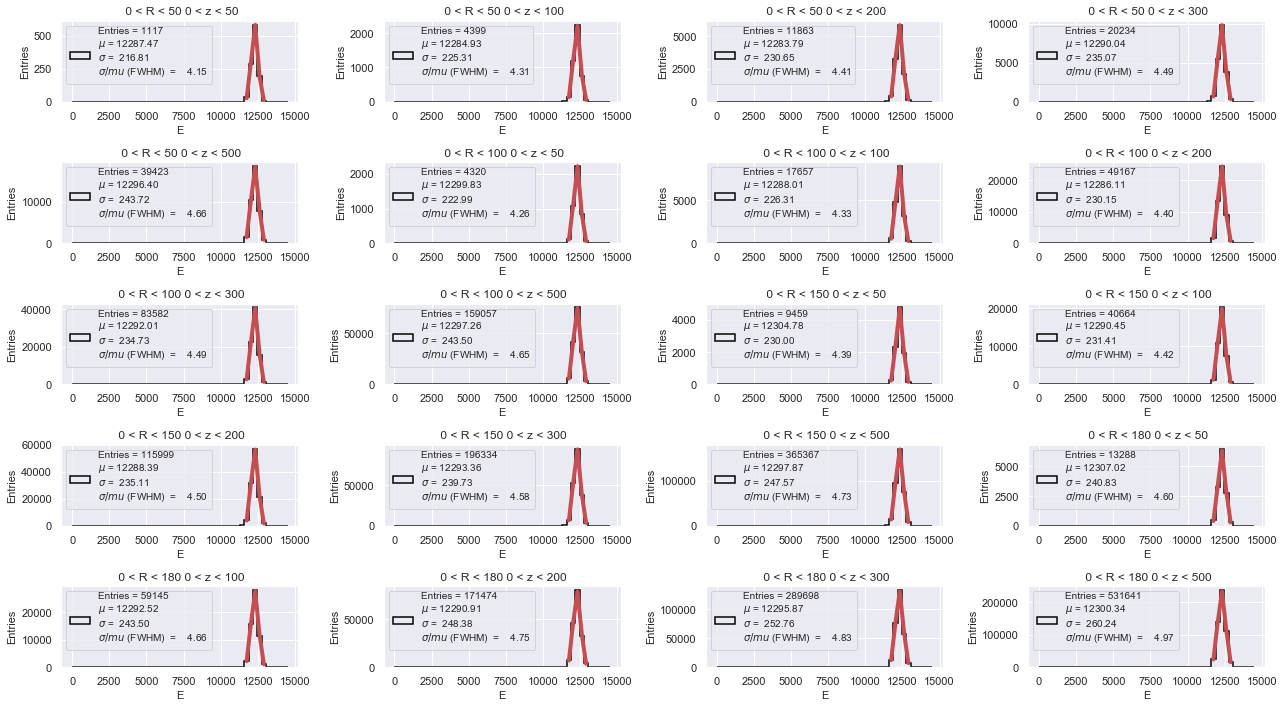

In [270]:
Ri = (50, 100,150,180)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, kse.R, kse.Z, kse.E,
                    enbins = 50,
                    erange = e_range,
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

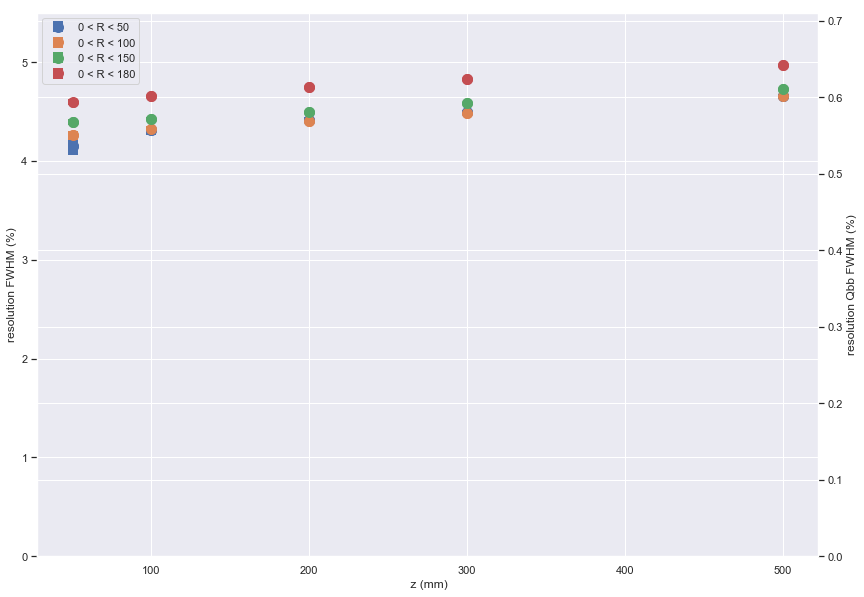

In [271]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,5.5))

## On energy corrections as a function of time
- The analysis of this run shows that if lifetime does not change too much with time within a run (e.g, 24 hours), time-dependent corrections may not be needed.

## Does correction improve using a more precise energy map?

### Trying to use geometrical map from runs 6349_6353

In [272]:
emap_path = '/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_6349_6353.h5'

In [273]:
emaps = read_maps(filename=emap_path)

KeyError: 'No object named mapinfo in the file'

In [ ]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 4500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [ ]:
norm = amap_max(emaps)

In [ ]:
ti = timeit(e0_xy_correction)
E1 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

In [ ]:
ti = timeit(lt_xy_correction)
E2 = ti(E1, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)



In [ ]:
kse2 = kr_event(dst, DT, E2, dst.S2q, sel)  # kse = krypton selected event

In [ ]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(kse2.Z, kse2.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kse2.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

In [ ]:
fc = fit_energy(kse2.E, nbins=100, range=(12000, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

#### No substantial change using a high resolution energy map

## Outlook:

- Analysis of run shows that the simple strategy of 100 x 100 xy bin maps with no time dependence its enough to correct energy resolution.
- All dependences appear flat (for R < 180 cm).
- Resolution well behaved as a function of R and Z.
- In spite of fluctuation in lifetime with t, average value seems enough to achieve flat energy as a function of t and z.
- High statistics E0 map doest not improve (or worsen) resolution. 